<a href="https://colab.research.google.com/github/ninavergara605/capstone/blob/main/First_Deliverable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import re
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours as ENN
from imblearn.under_sampling import RepeatedEditedNearestNeighbours as RENN
from imblearn.under_sampling import CondensedNearestNeighbour as CNN

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data was pulled from: https://codstats.net/leaderboards/
google drive link: https://drive.google.com/file/d/1-AKWwcvuOcNxV_YkhRTxQYLMHcCNBOg-/view?usp=sharing

## Cleaning 

Rename raw columns and clean out special characters

In [3]:
matches = pd.read_csv('/content/drive/MyDrive/capstone/data/match_stats.csv')
percent_cols = ['Headshots %',	'Accuracy_x',	'Winrate']
matches[percent_cols] = matches[percent_cols].apply(lambda x: pd.to_numeric(x.str.replace('%','')))
df = matches.rename(columns={'Headshots %': 'player_perc_headshots'
                  ,'Accuracy_x':'player_perc_accuracy'
                  ,'Accuracy_y': 'match_accuracy'
                  ,'Headshots': 'match_headshot_count'
                  ,'Time Played': 'match_time_played'
                  ,'Score Per Minute': 'match_score_per_minute'
                  ,'Shot': 'match_shot_count'
                  ,'Hit': 'match_hit_count'
                  ,'totalXp': 'match_total_XP'
                  ,'medal_Xp': 'match_medal_XP'
                  ,'LongestStreak': 'match_longest_streak'
                  ,'cod_level': 'level'
                  ,'Winrate': 'player_perc_wins'
                  })
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['avg_lifetime'] = pd.to_numeric(df['avg_lifetime'].str.replace('sec', ''))
df = df[(df['level'] <= 155) & (df['level'] >=15)].drop(columns='unnamed:_0')
df.head()

,rank,profile_href,gaming_system,handle,level,kda_ratio,avg_lifetime,score_per_game,player_perc_headshots,player_perc_accuracy,player_perc_wins,match_date,score,match_accuracy,match_time_played,match_headshot_count,match_score_per_minute,match_shot_count,match_hit_count,match_total_xp,medalxp,match_longest_streak
0,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,5 Aug15:43,1225.0,22.0,9.0,4.0,144.0,158.0,34.0,7737.0,4925.0,5.0
1,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,31 Jul19:25,1350.0,45.0,8.0,4.0,176.0,29.0,13.0,16018.0,4700.0,12.0
2,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,31 Jul19:15,1325.0,75.0,8.0,2.0,169.0,16.0,12.0,16618.0,4900.0,12.0
3,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,31 Jul19:05,2630.0,25.0,9.0,1.0,308.0,103.0,26.0,27778.0,8720.0,22.0
4,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,31 Jul18:53,1525.0,59.0,10.0,5.0,159.0,22.0,13.0,19390.0,5460.0,7.0


Class imbalances:


*   Levels 55 and 155 are over represented
*   Levels under 55 are under represented



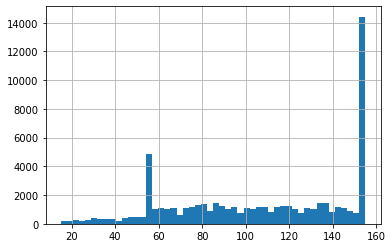

In [4]:
df['level'].hist(bins=50);


## Reclassifying the players that have all around extremely high stats

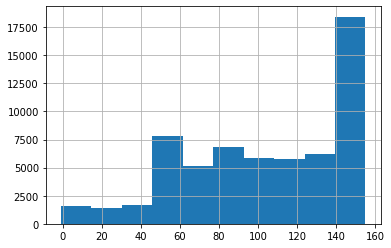

In [51]:
def label_outliers(df, cols):
  '''
  For each level, the mean is calculated for a column.
  If players score above three standard deviations above the mean then their name is added to the dictionary with the column appended
  If players are an outlier for three or more columns, their handle is returned
  '''
  suspect = defaultdict(list)
  for level in df['level'].unique():
    players = df[df['level'] == level]
    for col in cols:
      boundary = (3.5*players[col].std()) + players[col].mean()
      above_bound_players = list(players[players[col]>boundary].handle.unique())
      for sus in above_bound_players:
        suspect[sus].append(col)
  
  all_around_sus = [player for player, cols in suspect.items() if len(cols) > 4]
  return all_around_sus

cols = 'kda_ratio	avg_lifetime	score_per_game	player_perc_headshots	player_perc_accuracy	player_perc_wins	score	match_accuracy	match_time_played	match_headshot_count	match_score_per_minute	match_shot_count	match_hit_count	match_total_xp	medalxp	match_longest_streak'.split("\t")

sus_players = label_outliers(df, cols)
# Relabel the outlier players in a new df. Their flag value will be -1
relabeled = df.copy()
relabeled.loc[relabeled.handle.isin(sus_players), 'level'] = -1
relabeled['level'] = pd.to_numeric(relabeled.level)
relabeled.level.hist()

After relabeling, the class imbalances aren't as extreme. Definitely need to collect more data.

## To *slightly* dampen the effects of class imbalances, over and under sampling will be applied

In [8]:
def arr_to_df(df, X_arr, y_arr):
  '''
  df: dataframe to extract column names from
  X_arr: nested array,  to be reformated into dataframe. 
  Y_arr: 1-d array, to be reformated into a Series
  '''
  try:
    columns = df.select_dtypes(exclude='object').drop(columns=[ 'level']).columns
  except:
    columns = df.select_dtypes(exclude='object').columns
  X = pd.DataFrame(X_arr, columns=columns)
  y = pd.Series(y_arr)
  return X,y

Trying out imblearn's smote & edited nearest neighbor combo function

AxesSubplot(0.125,0.125;0.775x0.755)


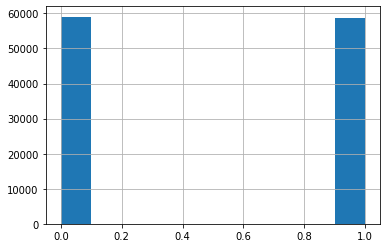

In [54]:

_relabeled = relabeled.dropna()
X = _relabeled.select_dtypes(exclude='object').drop(columns=['level'])
y = _relabeled['level']
binary_y = y.copy()
binary_y.loc[binary_y>0] = 0
binary_y.loc[binary_y<0] = 1


smoteenn= SMOTEENN(enn=ENN(n_neighbors=3), smote=SMOTE(k_neighbors=3))
X_smoteenn, y_smoteenn=smoteenn.fit_resample(X,binary_y)
X_smoteenn_df, y_smoteenn_df = arr_to_df(relabeled, X_smoteenn, y_smoteenn)
print(y_smoteenn_df.hist())

ENN down sampled the two majority classes and smote upsampled everything but the flagged values

In [62]:
def over_under_sample(df, under_sample_funcs):
  _df = df.dropna()
  X = _df.select_dtypes(exclude='object').drop(columns=['level'])
  y = _df['level']
  binary_y = y.copy()
  binary_y.loc[binary_y>0] = 0
  binary_y.loc[binary_y<0] = 1

  res = {}
  for (under_tag, under_func) in under_sample_funcs:
    try:
      under_samp_X, under_samp_y = under_func.fit_resample(X,y)
      smote = SMOTE(k_neighbors=1)
      over_samp_X, over_samp_y = smote.fit_resample(under_samp_X, under_samp_y)
      res[under_tag] = arr_to_df(_df, over_samp_X,over_samp_y)
    except ValueError:
      pass
  
  return res

renn = RENN(sampling_strategy=[55,155],n_neighbors=3)
enn = ENN(n_neighbors=3)
cnn = CNN(sampling_strategy=[55,155])
under_sample_funcs = [('renn', renn), ('enn', enn), ('cnn', cnn)]

res = over_under_sample(relabeled, under_sample_funcs)

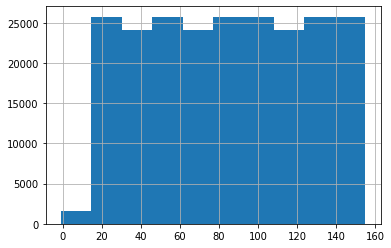

In [63]:
res['renn'][1].hist()

In [ ]:
res['enn'][1].hist()

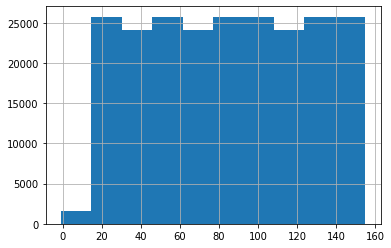

In [65]:
res['cnn'][1].hist()

SMOTE is probably having a hard up sampling the outliers because their values are so extreme. I'll be pulling from the top of the leaderboards to find some more data to flag this weekend. I can bootstrap and random sample the flagged values.

I was originally avoiding the cheaters because I thought that would interfere with smurf detection. I recently found out that COD has hacks, not smurfs.

Only. Model. Games. You. Play.

## Scaling and train-test split

In [66]:
X,y = X_smoteenn_df.copy(), y_smoteenn_df.copy() # Picking a resampled df with a lower number of samples per class until I pull more data

X_train, X_test, y_train, y_test = train_test_split(X,y)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_df, y_train_series = arr_to_df(X, X_train_sc, y_train)

## EDA

### Graph Functions

In [24]:
def scatter_plot(df, xcol, ycol, group_col='level', s=None, legend=False):
  df_avg = df.groupby(group_col).mean().reset_index()
  df_avg_regular = df_avg[df_avg.level != -1]
  df_avg_outlier = df_avg[df_avg.level == -1]
  kwargs_reg = {'x':xcol
              ,'y': ycol
              ,'data':df_avg_regular
              ,'hue':group_col
              ,'palette':'mako'
              ,'legend': legend
              }
  if s:
    kwargs_reg['size'] = s
  ax = sns.scatterplot(**kwargs_reg)
  ax.scatter(df_avg_outlier[xcol], df_avg_outlier[ycol], c='red')
  if legend:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


### Overall Stats

features:
*   kda_ratio
*   avg_lifetime
*   score_per_game
*   player_perc_headshots
*   player_perc_accuracy
*   player_perc_wins

Outlier averages are represented with the red dots
The 'regular' player dots are colored from dark (low-level) to light (high-level)

In [25]:
#doing eda on a dataset that has all level labels to see if there's any groupings
eda_df = res['renn'][0].copy()
eda_df['level'] = res['renn'][1]

overall_stats_cols = ['kda_ratio'
                  ,'avg_lifetime'
                  ,'score_per_game'
                  ,'player_perc_headshots'
                  ,'player_perc_accuracy'
                  ,'player_perc_wins']

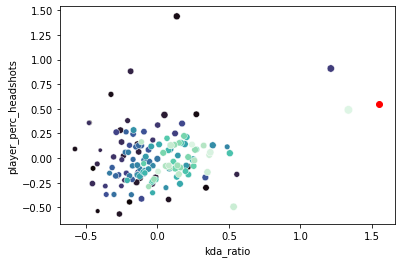

In [26]:
scatter_plot(eda_df,'kda_ratio','player_perc_headshots', s='player_perc_accuracy')

Percentage headshots seemed grouped together so I'm not surpised by the lack of spread between levels. 

Outliers seem to have a very high KDA compared to the rest of the group

#### KDA Ratio and Accuracy 

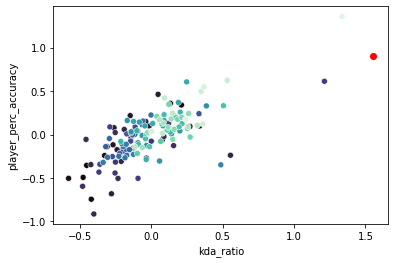

In [27]:
scatter_plot(eda_df,'kda_ratio','player_perc_accuracy')

Seems like players generally have a higher KDA and accuracy score as their level increases.

Hopefully more data will make the trends more apparent 

Unusuallly high KDA and Accuracy for the outlier groups

#### Using KDA Ratio to tease out other features that separate the cheaterz
KDA Ratio & Score per game

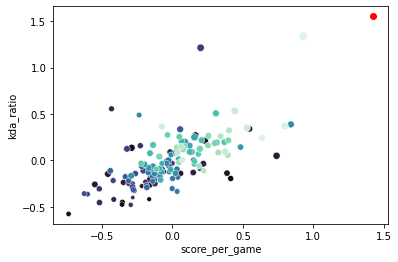

In [35]:
scatter_plot(eda_df,'score_per_game','kda_ratio', s='player_perc_accuracy')

Beautiful. Still pretty jumbled in the 55-155 range but the outliers clearly surpass the average on both metrics

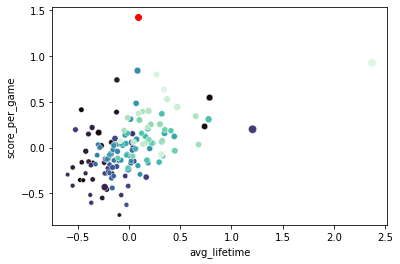

In [30]:
scatter_plot(eda_df,'avg_lifetime','score_per_game', s='kda_ratio')

Looks like the target class *somehow* scores a massive amount of points within a short time window.

## Match Statistics
*Note: These statistics are from each player's last 5 games. The COD API has a reCaptcha on their login due to a crackdown on third party stat tracking websites, so I'm unable to pull a lifetime match history ...at the moment.*

features: 
*   score
*   match_accuracy
*   match_time_played
*   match_headshot_count
*   match_score_per_minute
*   match_shot_count
*   match_hit_count
*   match_total_xp
*   medalxp
*   match_longest_streak

#### Match score and accuracy

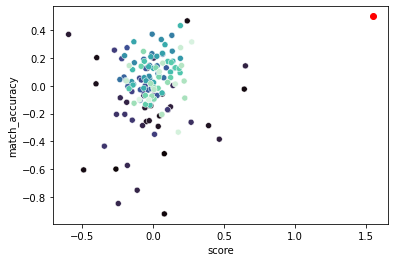

In [38]:
scatter_plot(eda_df,'score','match_accuracy')

Looks like match score could be an excellent feature for labeling the hackers  

#### Match headshot count and time played

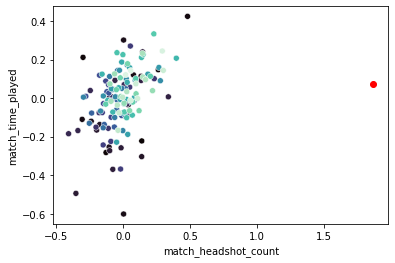

In [39]:
scatter_plot(eda_df,'match_headshot_count','match_time_played')

Match time played mirrors overall time played stats, the outliers seem to fall within the group. However, match headshot count truly separates the cheaters from the rest

#### Match headshot count and shot count

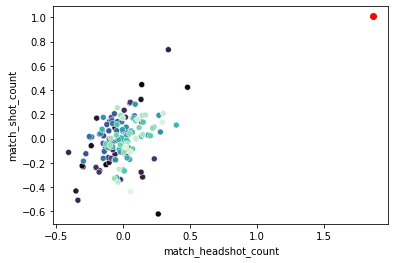

In [40]:
scatter_plot(eda_df,'match_headshot_count','match_shot_count')

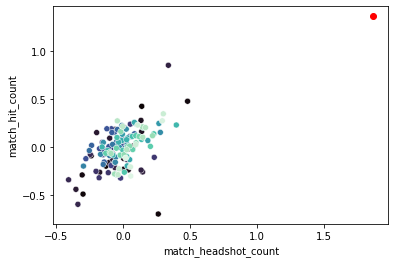

In [41]:
scatter_plot(eda_df,'match_headshot_count','match_hit_count')

So, these game hacks allow a player to spray bullets and rake in headshots with an extremely high accuracy. I need to ask these players a few questions.

## New Discoveries

I've recently found out that ranks (aka levels) reset after every season if you're above a certain level. So, a lot of my mid-upper tier players aren't their 'true' ranks.

Due to this revelation, I'll be building a classifier that identifies whether or not an individual is using software to enhance their gameplay.

DON'T. MODEL. GAMES. YOU. DON'T. PLAY. (Witcher 3 wya?)

41.0

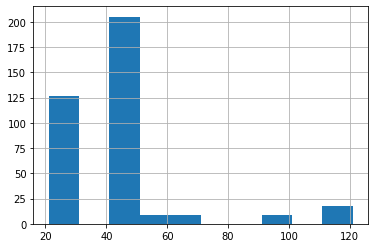

In [37]:
df[df['level'] == 60]['avg_lifetime'].hist()
df[df['level'] == 60]['avg_lifetime'].unique()
df['avg_lifetime'].median()

As seen above, for most of my features in the levels between 55-155, there are two distinct groups. I could probably filter with the median and reassign if need be.

### Dummy Accuracy: always predicts the majority class

In [68]:
dummy_accuracy = len(y_train[y_train == 0])/ len(y_train)
dummy_accuracy

0.5007645346532411

## First Simple Model

Logistic regression 

In [72]:
target_features = ['match_headshot_count','match_hit_count','match_shot_count', 'score', 'kda_ratio']

binary_y = y_train.copy()
binary_y.loc[binary_y>0] = 0
binary_y.loc[binary_y<0] = 1

X_train_filt = X_train[target_features]
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train_filt, y_train)
np.mean(clf.scores_[1])

0.7404082327200325